In [3]:
!pip install adversarial-robustness-toolbox

  Using cached https://files.pythonhosted.org/packages/31/94/aabfafdf4ce5b0995a8a49765255886a798f663b4ee0b63e24b7e2c33b69/Adversarial_Robustness_Toolbox-0.3.0-py3-none-any.whl
    100% |████████████████████████████████| 890kB 10.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for html5lib ... done
  Stored in directory: /Users/kev/Library/Caches/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 2.1.3
    Uninstalling bleach-2.1.3:
      Successfully uninstalled bleach-2.1.3


In [68]:
%matplotlib inline 

from __future__ import absolute_import, division, print_function, unicode_literals
from os.path import abspath
import time
import sys
sys.path.append(abspath('.'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from art.classifiers import KerasClassifier

import art
from art.attacks import DeepFool, BasicIterativeMethod, FastGradientMethod, SaliencyMapMethod, CarliniL2Method, NewtonFool, UniversalPerturbation
from art.defences import SpatialSmoothing, FeatureSqueezing, GaussianAugmentation, LabelSmoothing
from art.utils import load_mnist_raw, preprocess, random_targets

## Helper Methods

In [115]:
def create_nn(min_, max_):
    """ Create a simple 2 hidden layer 64 node neural net. """
    model = Sequential()
    model.add(Dense(64, input_dim=784, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    classifier = KerasClassifier((min_, max_), model=model)
    return classifier

In [117]:
def extract_num(matrix, i):
    return matrix[i].reshape(28,28)

In [137]:
def plot(matrix, i, title=None):
    img = extract_num(matrix, i)
    plt.imshow(img, interpolation='nearest')
    if title:
        plt.title(title, fontsize=32)

In [29]:
def evaluate(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, y_train_adv, y_test_adv, classifier, file):
    preds = np.argmax(classifier.predict(x_train), axis=1)
    acc = np.sum(preds == np.argmax(y_train, axis=1)) / y_train.shape[0]
    print("TRAIN: %.2f%% \n" % (acc * 100))
    file.write("  TRAIN: %.2f%% \n" % (acc * 100))
    
    preds = np.argmax(classifier.predict(x_train_adv), axis=1)
    acc = np.sum(preds == np.argmax(y_train_adv, axis=1)) / y_train_adv.shape[0]
    print("TRAIN-ADVERSARY: %.2f%% \n" % (acc * 100))
    file.write("  TRAIN-ADVERSARY: %.2f%% \n" % (acc * 100))
    
    preds = np.argmax(classifier.predict(x_test), axis=1)
    acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    print("TEST: %.2f%% \n" % (acc * 100))
    file.write("  TEST: %.2f%% \n" % (acc * 100))
    
    preds = np.argmax(classifier.predict(x_test_adv), axis=1)
    acc = np.sum(preds == np.argmax(y_test_adv, axis=1)) / y_test_adv.shape[0]
    print("TEST-ADVERSARY: %.2f%% \n" % (acc * 100))
    file.write("  TEST-ADVERSARY: %.2f%% \n" % (acc * 100))

### Attack Functions

In [30]:
def atk_DeepFool(x_train, x_test, y_train, y_test, classifier, file):
    #print('Create DeepFool attack \n')
    adv_crafter = DeepFool(classifier, max_iter=15)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)
    
    print("After DeepFool Attack \n")
    file.write("==== DeepFool Attack==== \n")
    evaluate(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, y_train, y_test, classifier, file)
    return x_test_adv, x_train_adv

In [31]:
def atk_BasicIterative(x_train, x_test, y_train, y_test, classifier, file):
    #print('Create BasicIterativeMethod attack \n')
    adv_crafter = BasicIterativeMethod(classifier, eps=1, eps_step=0.1)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)
    
    print("After BasicIterative Attack  \n")
    file.write("==== BasicIterative Attack==== \n")
    evaluate(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, y_train, y_test, classifier, file)
    return x_test_adv, x_train_adv

In [32]:
def atk_FastGradient(x_train, x_test, y_train, y_test, classifier, file):
    epsilon = 0.1
    #print('Create FastGradientMethod attack \n')
    adv_crafter = FastGradientMethod(classifier)
    x_train_adv = adv_crafter.generate(x_train, eps=epsilon)
    x_test_adv = adv_crafter.generate(x_test, eps=epsilon)
    
    print("After FastGradient Attack  \n")
    file.write("==== FastGradient Attack==== \n")
    evaluate(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, y_train, y_test, classifier, file)
    return x_test_adv, x_train_adv

In [33]:
def atk_JSMA(x_train, x_test, y_train, y_test, classifier, file):
    #print('Create JSMA attack \n')
    adv_crafter = SaliencyMapMethod(classifier, theta=1, gamma = 0.5)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)
    
    print("After JSMA Attack  \n")
    file.write("==== JSMA Attack==== \n")
    evaluate(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, y_train, y_test, classifier, file)
    return x_test_adv, x_train_adv

In [34]:
def atk_CarliniL2(x_train, x_test, y_train, y_test, classifier, file):
    #print('Create CarliniL2Method attack \n')
    adv_crafter = CarliniL2Method(classifier, targeted=True, max_iter=10, binary_search_steps=1, learning_rate=1, initial_const=10, decay=0)
    params = {'y': random_targets(y_test, classifier.nb_classes)}
    x_train_adv = adv_crafter.generate(x_train, **params)
    x_test_adv = adv_crafter.generate(x_test, **params)
    
    print("After CarliniL2 Attack  \n")
    file.write("==== CarliniL2 Attack==== \n")
    evaluate(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, y_train, y_test, classifier, file)
    return x_test_adv, x_train_adv

In [35]:
def atk_NewtonFool(x_train, x_test, y_train, y_test, classifier, file):
    adv_crafter = NewtonFool(classifier, max_iter=20)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)

    print("After NewtonFool Attack  \n")
    file.write("==== NewtonFool Attack==== \n")
    evaluate(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, y_train, y_test, classifier, file)
    return x_test_adv, x_train_adv

In [36]:
def atk_UniPerturb(x_train, x_test, y_train, y_test, classifier, file):
    attack_params = {"attacker": "fgsm", "attacker_params": {"max_iter": 3}}
    adv_crafter = UniversalPerturbation(classifier)
    x_train_adv = adv_crafter.generate(x_train, **attack_params)
    x_test_adv = adv_crafter.generate(x_test, **attack_params)

    print("After UniversalPerturbation FGSM Attack  \n")
    file.write("==== UniversalPerturbation FGSM Attack==== \n")
    evaluate(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, y_train, y_test, classifier, file)
    return x_test_adv, x_train_adv

### Defense Functions

In [38]:
def def_AdversarialTraining(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_, attack_list, file):
    # print result
    print("After AdversarialTraining Defense\n")
    file.write("==== AdversarialTraining Defense==== \n")
    train_num = 60000
    test_num = 10000
    for k in range (7):
        # expand the training set with the adversarial samples
        x_train_aug = np.append(x_train, x_train_adv[k*train_num:(k+1)*train_num], axis=0)
        y_train_aug = np.append(y_train, y_train, axis=0)
        # retrain the Network on the extended dataset
        classifier = create_nn(min_, max_)
        classifier.fit(x_train_aug, y_train_aug, nb_epochs=5, batch_size=50)
        
        file.write("==== %s Attack ====\n" % (attack_list[k]))
        evaluate(x_train, x_test, y_train, y_test, x_train_adv[k*train_num:(k+1)*train_num], x_test_adv[k*test_num:(k+1)*test_num], y_train, y_test, classifier, file)

In [37]:
def def_SpatialSmoothing(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_, attack_list, file):
    train_num = 60000
    test_num = 10000
    # reshape to smooth
    x_train = x_train.reshape(train_num, 28, 28, 1)
    x_test = x_test.reshape(test_num, 28, 28, 1)
    x_train_adv = x_train_adv.reshape(7*train_num, 28, 28, 1)
    x_test_adv = x_test_adv.reshape(7*test_num, 28, 28, 1)
    # smooth
    smoother = SpatialSmoothing()
    x_train_smooth = smoother(x_train, window_size=3)
    x_test_smooth = smoother(x_test, window_size=3)
    x_train_adv_smooth = smoother(x_train_adv, window_size=3)
    x_test_adv_smooth = smoother(x_test_adv, window_size=3)
    # reshape back
    x_train_smooth = x_train_smooth.reshape(train_num, 784)
    x_test_smooth = x_test_smooth.reshape(test_num, 784)
    x_train_adv_smooth = x_train_adv_smooth.reshape(7*train_num, 784)
    x_test_adv_smooth = x_test_adv_smooth.reshape(7*test_num, 784)
    
    # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train_smooth, y_train, nb_epochs=5, batch_size=50)
    
    # print result
    print("After SpatialSmoothing Defense\n")
    file.write("==== SpatialSmoothing Defense==== \n")
    for k in range (7):
        file.write("==== %s Attack ====\n" % (attack_list[k]))
        evaluate(x_train_smooth, x_test_smooth, y_train, y_test, x_train_adv_smooth[k*train_num:(k+1)*train_num], x_test_adv_smooth[k*test_num:(k+1)*test_num], y_train, y_test, classifier, file)

In [39]:
def def_FeatureSqueezing(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_, attack_list, file):
    train_num = 60000
    test_num = 10000
    squeezer = FeatureSqueezing()
    x_train_squeeze = squeezer(x_train, bit_depth=2)
    x_test_squeeze = squeezer(x_test, bit_depth=2)
    x_train_adv_squeeze = squeezer(x_train_adv[0:6*train_num], bit_depth=2)
    x_test_adv_squeeze = squeezer(x_test_adv[0:6*test_num], bit_depth=2)
    
    # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train_squeeze, y_train, nb_epochs=5, batch_size=50)
    
    # print result
    print("After FeatureSqueezing Defense\n")
    file.write("==== FeatureSqueezing Defense==== \n")
    
    for k in range (6):
        file.write("==== %s Attack ====\n" % (attack_list[k]))
        evaluate(x_train_squeeze, x_test_squeeze, y_train, y_test, x_train_adv_squeeze[k*train_num:(k+1)*train_num], x_test_adv_squeeze[k*test_num:(k+1)*test_num], y_train, y_test, classifier, file)

In [40]:
def def_GaussianAugmentation(x_raw, x_raw_test, y_raw, y_raw_test, x_train_adv, x_test_adv, y_train, y_test, min_, max_, attack_list, file):
    train_num = 60000
    test_num = 10000
    # gaussian augmentation
    ga = GaussianAugmentation(sigma=150)
    x_train_aug, y_train_aug = ga(x_raw, y_raw)
    x_test_aug, y_test_aug = ga(x_raw_test, y_raw_test)
    x_train_aug, y_train_aug = preprocess(x_train_aug, y_train_aug)
    x_test_aug, y_test_aug = preprocess(x_test_aug, y_test_aug)
    x_train_aug = x_train_aug.reshape(2*train_num, 784)
    x_test_aug = x_test_aug.reshape(2*test_num, 784)
    
    # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train_aug, y_train_aug, nb_epochs=5, batch_size=50)
    
    # print result
    print("After GaussianAugmentation Defense\n")
    file.write("==== GaussianAugmentation Defense==== \n")
    for k in range (7):
        file.write("==== %s Attack ====\n" % (attack_list[k]))
        evaluate(x_train_aug, x_test_aug, y_train_aug, y_test_aug, x_train_adv[k*train_num:(k+1)*train_num], x_test_adv[k*test_num:(k+1)*test_num], y_train, y_test, classifier, file)

In [41]:
def def_LabelSmoothing(x_train, x_test, y_train, y_test, x_train_adv, x_test_adv, min_, max_, attack_list, file):
    labelsmoother = LabelSmoothing()
    x_train, y_train_smooth = labelsmoother(x_train, y_train, max_value=.8)
    x_test, y_test_smooth = labelsmoother(x_test, y_test, max_value=.8)
    
     # train network
    classifier = create_nn(min_, max_)
    classifier.fit(x_train, y_train_smooth, nb_epochs=5, batch_size=50)
    
    # print result
    print("After LabelSmoothing Defense\n")
    file.write("==== LabelSmoothing Defense==== \n")
    train_num = 60000
    test_num = 10000
    for k in range (7):
        file.write("==== %s Attack ====\n" % (attack_list[k]))
        evaluate(x_train, x_test, y_train_smooth, y_test_smooth, x_train_adv[k*train_num:(k+1)*train_num], x_test_adv[k*test_num:(k+1)*test_num], y_train, y_test, classifier, file)   

## Preprocessing

### Read MNIST dataset (x_raw contains the original images):

In [42]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist_raw()
x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

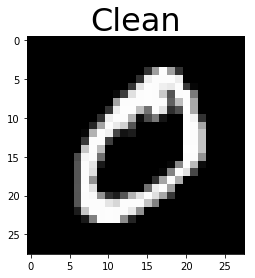

In [160]:
plot(x_raw, 1, 'Clean')

### Create and train baseline network

In [43]:
classifier = create_nn(min_, max_)
classifier.fit(x_train, y_train, nb_epochs=5, batch_size=50)

Epoch 1/5
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0132 - acc: 0.9143
Epoch 2/5
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0063 - acc: 0.9603
Epoch 3/5
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0049 - acc: 0.9689
Epoch 4/5
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0039 - acc: 0.9756
Epoch 5/5
1200/1200 [==============================] - 2s 2ms/step - loss: 0.0035 - acc: 0.9782


## Construct Adversarial Images on MNIST

In [50]:
adv_test = {}
adv_train = {}

### Deepfool

In [162]:
%time adv_test['DeepFool'], adv_train['DeepFool'] = atk_DeepFool(x_train, x_test, y_train, y_test, classifier, baseline_file)
np.save('adv/test_DeepFool', adv_test['DeepFool'])
np.save('adv/train_DeepFool', adv_train['DeepFool'])

KeyboardInterrupt: 

KeyError: 'DeepFool'

### BasicIterative

In [89]:
%time adv_test['BasicIterative'], adv_train['BasicIterative'] = atk_BasicIterative(x_train, x_test, y_train, y_test, classifier, baseline_file)
np.save('adv/BasicIterative', adv_test['BasicIterative'])
np.save('adv/BasicIterative', adv_train['BasicIterative'])

After BasicIterative Attack  

TRAIN: 98.04% 

TRAIN-ADVERSARY: 16.20% 

TEST: 97.08% 

TEST-ADVERSARY: 17.91% 

CPU times: user 1min 6s, sys: 22.7 s, total: 1min 29s
Wall time: 1min 7s


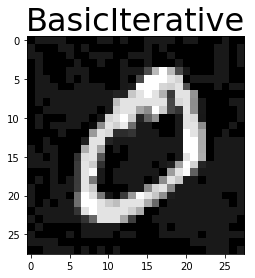

In [159]:
plot(adv_train['BasicIterative'], 1, 'BasicIterative')

### FGSM

In [163]:
%time adv_test['FGSM'], adv_train['FGSM'] = atk_FastGradient(x_train, x_test, y_train, y_test, classifier, baseline_file)
np.save('adv/test_FGSM', adv_test['FGSM'])
np.save('adv/train_FGSM', adv_train['FGSM'])

After FastGradient Attack  

TRAIN: 98.04% 

TRAIN-ADVERSARY: 16.40% 

TEST: 97.08% 

TEST-ADVERSARY: 18.38% 

CPU times: user 3.94 s, sys: 955 ms, total: 4.9 s
Wall time: 2.92 s


FileNotFoundError: [Errno 2] No such file or directory: 'adv/test_FGSM.npy'

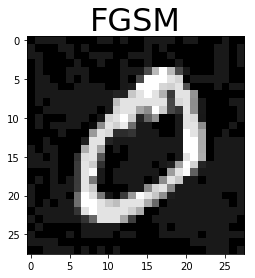

In [145]:
plot(adv_train['FGSM'], 1, 'FGSM')

### JSMA
Slow but strong adversarial examples. Preceded FGSM.

In [54]:
%time adv_test['JSMA'], adv_train['JSMA'] = atk_JSMA(x_train, x_test, y_train, y_test, classifier, baseline_file)
np.save('adv_test_JSMA', adv_test['JSMA'])
np.save('adv_train_JSMA', adv_train['JSMA'])

KeyboardInterrupt: 

### Carlini (L2)
Slow but considered one of the best iterative attacks.

In [55]:
%time adv_test['Carlini'], adv_train['Carlini'] = atk_CarliniL2(x_train, x_test, y_train, y_test, classifier, baseline_file)
np.save('adv_test_Carlini', adv_test['Carlini'])
np.save('adv_train_Carlini', adv_train['Carlini'])

KeyboardInterrupt: 

### NewtonFool

In [56]:
%time adv_test['NewtonFool'], adv_train['NewtonFool'] = atk_NewtonFool(x_train, x_test, y_train, y_test, classifier, baseline_file)
np.save('adv_test_NewtonFool', adv_test['NewtonFool'])
np.save('adv_train_NewtonFool', adv_train['NewtonFool'])

SystemError: <built-in function IsSequence> returned a result with an error set

### Universal Perturbation

In [57]:
%time adv_test['UniPerturb'], adv_train['UniPerturb'] = atk_UniPerturb(x_train, x_test, y_train, y_test, classifier, baseline_file)
np.save('adv_test_UniPerturb', adv_test['UniPerturb'])
np.save('adv_train_UniPerturb', adv_train['UniPerturb'])

KeyboardInterrupt: 

## Benchmark Attacks against Defenses

In [1]:
attack_list = ["DeepFool", "BasicIterative", "FastGradient", "JSMA", "CarliniL2", "NewtonFool", "UniPerturb"]
def_SpatialSmoothing(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_, attack_list, defense_1_file)
def_AdversarialTraining(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_, attack_list, defense_2_file)
def_FeatureSqueezing(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_, attack_list, defense_3_file)
def_GaussianAugmentation(x_raw, x_raw_test, y_raw, y_raw_test, x_train_adv_all, x_test_adv_all, y_train, y_test, min_, max_, attack_list, defense_4_file)
def_LabelSmoothing(x_train, x_test, y_train, y_test, x_train_adv_all, x_test_adv_all, min_, max_, attack_list, defense_5_file)

    100% |████████████████████████████████| 133kB 3.4MB/s 


Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1200/1200 [==============================] - 4s 3ms/step - loss: 0.0138 - acc: 0.9105
Epoch 2/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0067 - acc: 0.9577
Epoch 3/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0053 - acc: 0.9668
Epoch 4/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0043 - acc: 0.9733
Epoch 5/5
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0035 - acc: 0.9779
After DeepFool Attack 

TRAIN: 98.08% 

TRAIN-ADVERSARY: 79.81% 

TEST: 96.81% 

TEST-ADVERSARY: 78.79% 

--- 21.44216686487198 minutes ---
After BasicIterative Attack  

TRAIN: 98.08% 

TRAIN-ADVERSARY: 13.01% 

TEST: 96.81% 

TEST-ADVERSARY: 14.00% 

--- 22.480172216892242 minutes ---
After FastGradient Attack  

TRAIN: 98.08% 

TRAIN-ADVERSARY: 13.30% 

TEST: 96.81% 

TEST-ADVERSARY: 14.54% 

--- 22.538637300332386 minutes ---
After JSMA Attack  

